# Importing and hosting an ONNX model with Amazon Elastic Infernce

The [Open Neural Network Exchange](https://onnx.ai/) (ONNX) is an open format for representing deep learning models with its extensible computation graph model and definitions of built-in operators and standard data types.

In this example, we will use the ResNet-152v1 model from [Deep residual learning for image recognition](https://arxiv.org/abs/1512.03385). This model, along with many others, can be found at the [ONNX Model Zoo](https://github.com/onnx/models).

We will use the SageMaker Python SDK to host this ONNX model in SageMaker, and perform inference requests.

## Setup

First, we'll get the IAM execution role from our notebook environment, so that SageMaker can access resources in your AWS account later in the example.

In [1]:
from sagemaker import get_execution_role

role = get_execution_role()

## The hosting script

We'll need to provide a hosting script that can run on the SageMaker platform. This script will be invoked by SageMaker when we perform inference.

The script we're using here implements two functions:

* `model_fn()` - the SageMaker model server uses this function to load the model
* `transform_fn()` - this function is for using the model to take the input and produce the output

In [2]:
!pygmentize resnet152.py

from __future__ import print_function

import bisect
import json
import logging
import time
import random
import re
from collections import Counter, namedtuple
from itertools import chain, islice

import mxnet as mx
import mxnet.contrib.onnx as onnx_mxnet
import numpy as np
from mxnet import gluon, autograd, nd
from mxnet.io import DataIter, DataBatch, DataDesc
from mxnet.gluon import nn

logging.basicConfig(level=logging.DEBUG)


def model_fn(model_dir):
    """
    Load the onnx model. Called once when hosting service starts.

    :param: model_dir The directory where model files are stored.
    :return: a model
    """
    sym, arg_params, aux_params = onnx_mxnet.import_model('%s/resnet152v1.onnx' % model_dir) 
    # create module
    mod = mx.mod.Module(symbol=sym, data_names=['data'], label_names=None)
    mod.bind(for_training=False, data_shapes=[('data', [1, 3, 224, 224])], label_shapes=mod._label_shapes)
    mod.set_params(arg_params=arg_params, aux_params=aux_params, allow_mis

## Preparing the model

To create a SageMaker Endpoint, we'll first need to prepare the model to be used in SageMaker.

### Downloading the model

For this example, we will use a pre-trained ONNX model from the [ONNX Model Zoo](https://github.com/onnx/models), where you can find a collection of pre-trained models to work with. Here, we will download the [ResNet-152v1 model](https://s3.amazonaws.com/onnx-model-zoo/resnet/resnet152v1/resnet152v1.onnx) trained on ImageNet dataset.

In [3]:
import mxnet as mx
import matplotlib.pyplot as plt
import numpy as np
from mxnet.gluon.data.vision import transforms

mx.test_utils.download('https://s3.amazonaws.com/onnx-model-zoo/resnet/resnet152v1/resnet152v1.onnx')

'resnet152v1.onnx'

### Compressing the model data

Now that we have the model data locally, we will need to compress it and upload the tarball to S3 for the SageMaker Python SDK to create a Model

In [4]:
import tarfile

from sagemaker.session import Session

with tarfile.open('onnx_model.tar.gz', mode='w:gz') as archive:
    archive.add('resnet152v1.onnx')

model_data = Session().upload_data(path='onnx_model.tar.gz', key_prefix='model')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-968277166688


### Creating a SageMaker Python SDK Model instance

With the model data uploaded to S3, we now have everything we need to instantiate a SageMaker Python SDK Model. We'll provide the constructor the following arguments:

* `model_data`: the S3 location of the model data
* `entry_point`: the script for model hosting that we looked at above
* `role`: the IAM role used
* `framework_version`: the MXNet version in use, in this case '1.3.0'

You can read more about creating an `MXNetModel` object in the [SageMaker Python SDK API docs](https://sagemaker.readthedocs.io/en/latest/sagemaker.mxnet.html#mxnet-model).

In [5]:
from sagemaker.mxnet import MXNetModel

mxnet_model = MXNetModel(model_data=model_data,
                         entry_point='resnet152.py',
                         role=role,
                         framework_version='1.3.0')

## Creating an inference endpoint and attaching an EI accelerator

Now we can use our `MXNetModel` object to build and deploy an `MXNetPredictor`. This creates a SageMaker Model and Endpoint, the latter of which we can use for performing inference. 

We pass the following arguments to the deploy method:

* instance_count - how many instances to back the endpoint.
* instance_type - which EC2 instance type to use for the endpoint. For information on supported instance, please check here.
* accelerator_type - determines which EI accelerator type to attach to each of our instances. The supported types of accelerators can be found here: https://aws.amazon.com/sagemaker/pricing/instance-types/

### How our models are loaded
By default, the predefined SageMaker MXNet containers have a default model_fn, which determines how your model is loaded. The default model_fn loads an MXNet Module object with a context based on the instance type of the endpoint.

This applies for EI as well. If an EI accelerator is attached to your endpoint and a custom model_fn isn't provided, then the default model_fn will load the MXNet Module object with an EI context, mx.eia(). This default model_fn works with the default save function. If a custom save function was defined, then you may need to write a custom model_fn function. For more information on the model_fn.

In [6]:
%%time

predictor = mxnet_model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge', accelerator_type='ml.eia1.medium')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-968277166688
INFO:sagemaker:Creating model with name: sagemaker-mxnet-eia-2019-01-31-00-52-05-444
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-eia-2019-01-31-00-52-05-444


----------------------------------------------------------------------------!CPU times: user 382 ms, sys: 35.4 ms, total: 417 ms
Wall time: 6min 26s


## Performing inference

With our Endpoint deployed, we can now send inference requests to it. We'll use one image as an example here.

### Preparing the image

First, we'll download the image (and view it).

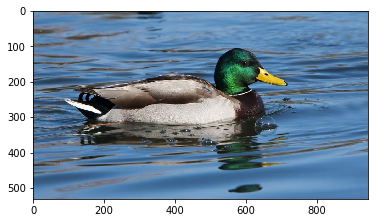

In [7]:
# Download image for inference
img_path = mx.test_utils.download('https://s3.amazonaws.com/onnx-mxnet/examples/mallard_duck.jpg')
img = mx.image.imread(img_path)
plt.imshow(img.asnumpy())

Now, we will preprocess inference image. We will resize it to 256x256, take center crop of 224x224, normalize image, add a dimension to batchify the image.

In [8]:
def preprocess(img):   
    transform_fn = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = transform_fn(img)
    img = img.expand_dims(axis=0)
    return img
input_image = preprocess(img)

### Sending the inference request

Now we can use the predictor object to classify the input image:

In [9]:
scores = predictor.predict(input_image.asnumpy())

To see the inference result, let's download and load synset.txt file containing class labels for ImageNet. The top 5 classes generated in order, along with the probabilities are:


In [10]:
mx.test_utils.download('https://s3.amazonaws.com/onnx-model-zoo/synset.txt')
with open('synset.txt', 'r') as f:
    labels = [l.rstrip() for l in f]

a = np.argsort(scores)[::-1]

for i in a[0:5]:
        print('class=%s ; probability=%f' %(labels[i],scores[i]))

class=n01847000 drake ; probability=0.999519
class=n02018207 American coot, marsh hen, mud hen, water hen, Fulica americana ; probability=0.000230
class=n01855032 red-breasted merganser, Mergus serrator ; probability=0.000130
class=n01855672 goose ; probability=0.000044
class=n09332890 lakeside, lakeshore ; probability=0.000022


## Deleting the Endpoint

Since we've reached the end, we'll delete the SageMaker Endpoint to release the instance associated with it.

In [11]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint with name: sagemaker-mxnet-eia-2019-01-31-00-52-05-444
